
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Nakajo Storms: Selection of representative cases using Maximum Dissimilarity (MaxDiss) algorithm (Camus et al. 2011)

inputs required: 
  * Synthetic TC parameters that affect the site (output of *notebook 05*)
  * number of representative cases to be selected using MaxDiss

in this notebook:
  * Analysis of historical and synthetic events
  * MDA selection of representative number of events

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import xarray as xr
import numpy as np

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.storms import Extract_Circle, GetCategoryChangeProbs
from teslakit.mda import MaxDiss_Simplified_NoThreshold

from teslakit.plotting.storms import Plot_TCs_Params_MDAvsSIM,Plot_TCs_Params_HISTvsSIM, Plot_TCs_Params_HISTvsSIM_histogram, Plot_Category_Change


In [3]:
def ibtrac_basin_fitting(x0, y0):
    '''
    Assigns cubic polynomial fitting curve coefficient for each basin of
    historical TCs data (IBTrACS)
    '''

    # determination of the location basin 
    if y0 < 0:                  basin = 5
    elif (y0 > 0) & (x0 > 0):   basin = 3
    else:                       print('Basin not defined')

    # cubic polynomial fitting curve for Ibtracs and each basin
    # TODO: obtain all basin fitting coefficients

    if basin == 3:      # West Pacific
        p1 = -7.77328602747578e-06
        p2 = 0.0190830514629838
        p3 = -15.9630945598490
        p4 = 4687.76462404360

    elif basin == 5:    # South Pacific
        p1 = -4.70481986864773e-05
        p2 = 0.131052968357409
        p3 = -122.487981649828
        p4 = 38509.7575283218

    return p1, p2, p3, p4



## Database and Site parameters

In [4]:
# --------------------------------------
# Teslakit database

# p_data = r'/media/administrador/HD/Dropbox/Guam/teslakit/data'
p_data=r'/Users/laurac/Dropbox/Guam/teslakit/data'

db = Database(p_data)

# set site
db.SetSite('GUAM')



In [3]:
# --------------------------------------
# load data and set parameters

# wave point longitude and latitude
pnt_lon = 144.75
pnt_lat = 13.44

# radius for TCs selection (º)
r1 = 14
r2 = 4

# MDA number of cases
num_sel_mda = 500

# Load Nakajo simulations
TCs_Nakajo = db.Load_TCs_Nakajo()


In [4]:
# Get Nakajo TCs at the study area

# dictionary with needed variable names
d_vns = {
    'longitude':'ylon_TC',
    'latitude':'ylat_TC',
    'time': 'yts',
    'pressure':'yCPRES',
}

# Extract Nakajo TCs inside r2
_, TCs_r2_sim_params = Extract_Circle(TCs_Nakajo, pnt_lon, pnt_lat, r2, d_vns)
_, TCs_r1_sim_params = Extract_Circle(TCs_Nakajo, pnt_lon, pnt_lat, r1, d_vns)

print(TCs_r2_sim_params)

# Store Nakajo TCs parameters
db.Save_TCs_r2_sim_params(TCs_r2_sim_params)


<xarray.Dataset>
Dimensions:        (storm: 55138)
Coordinates:
  * storm          (storm) int64 22 50 52 53 58 ... 999972 999975 999977 999986
Data variables:
    pressure_min   (storm) float64 978.2 966.3 944.0 ... 997.3 1.007e+03 951.5
    pressure_mean  (storm) float64 990.9 973.2 961.2 ... 998.2 1.007e+03 953.6
    velocity_mean  (storm) float64 20.13 48.82 14.66 20.26 ... 19.85 12.69 31.77
    gamma          (storm) float64 182.2 112.5 73.51 96.75 ... 123.0 136.2 111.7
    delta          (storm) float64 154.4 127.4 76.57 139.3 ... 191.0 172.5 50.89
    category       (storm) int64 2 2 4 2 1 3 1 1 2 4 4 ... 2 0 5 3 4 1 0 1 1 0 3
    dmin_date      (storm) float64 48.0 306.0 123.0 114.0 ... 42.0 0.0 120.0
    last_date      (storm) float64 192.0 400.5 418.5 336.0 ... 318.0 132.0 259.5
    index_in       (storm) int64 9 116 32 34 0 25 18 29 ... 29 26 0 22 12 0 38
    index_out      (storm) int64 22 122 54 44 14 37 38 36 ... 37 44 2 37 16 1 41
Attributes:
    point_lon:  144.75
    p

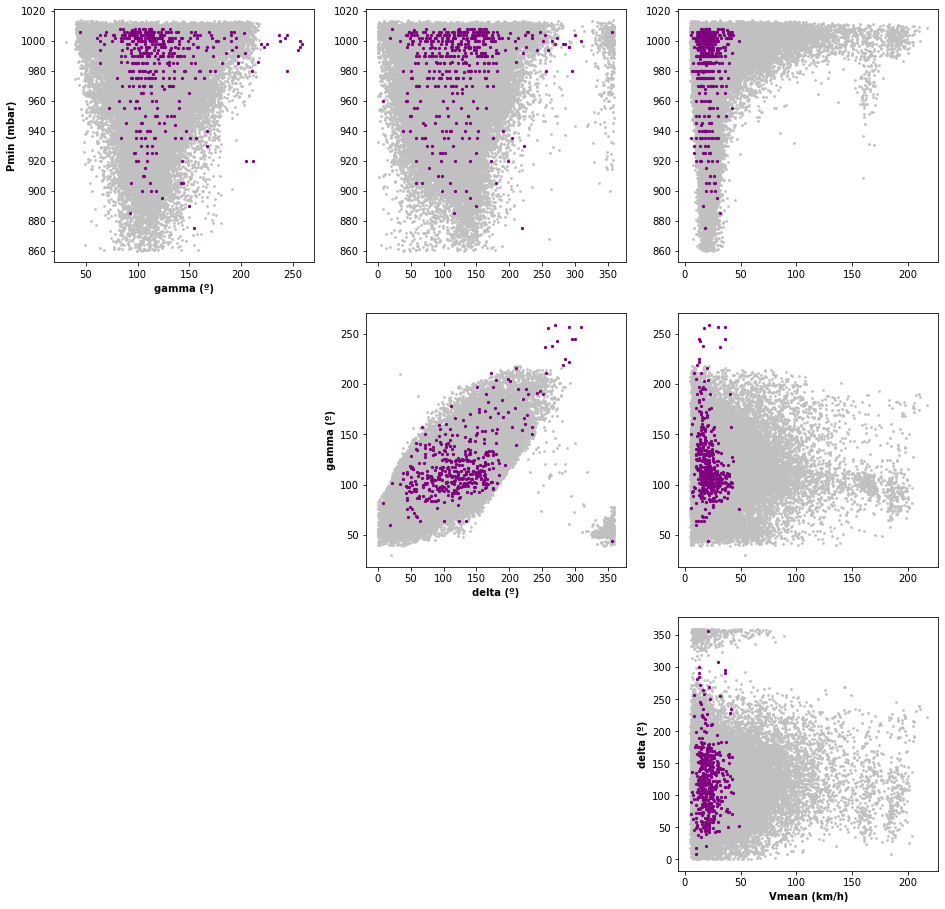

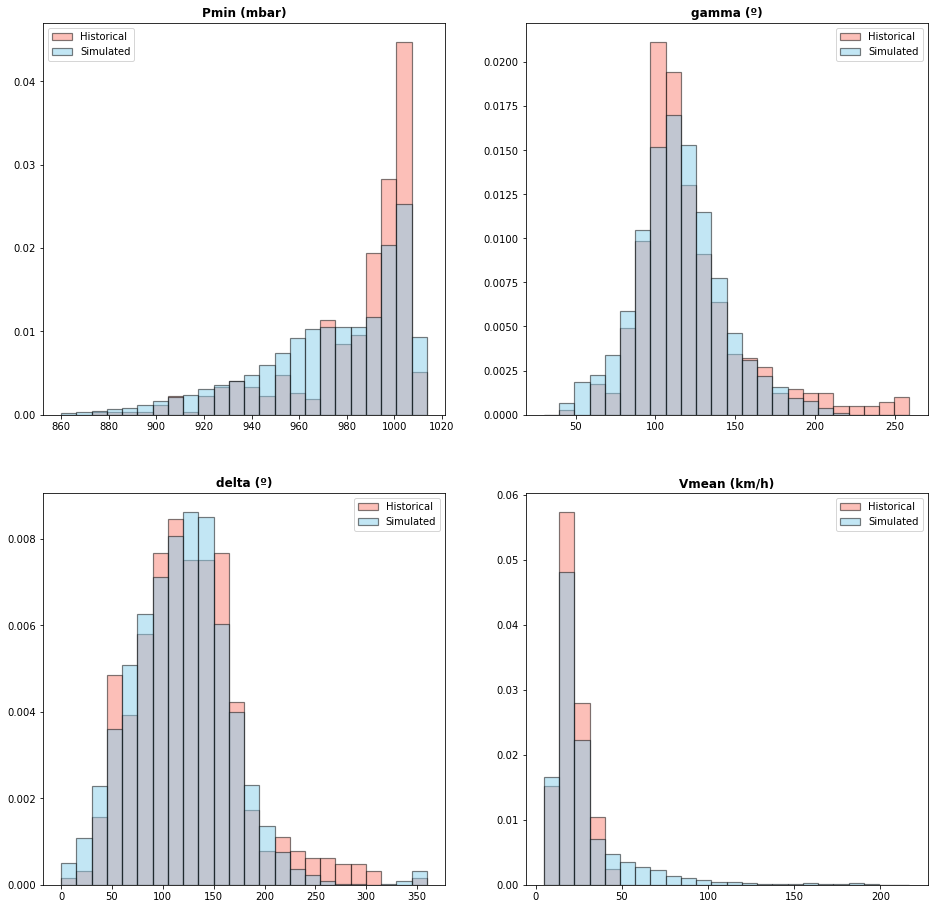

In [5]:
# Historical vs Nakajo Simulation parameters: 
_, TCs_r2_hist_params = db.Load_TCs_r2_hist()  # historical TCs parameters inside radius 2

# scatter plot
Plot_TCs_Params_HISTvsSIM(TCs_r2_hist_params, TCs_r2_sim_params);

# histogram
Plot_TCs_Params_HISTvsSIM_histogram(TCs_r2_hist_params, TCs_r2_sim_params);
                        

#### FILTER PRESSURE AND VELOCITY DATA AND SAVE

In [32]:
# min_pressure_min=0.9*np.nanmin(TCs_r2_hist_params.pressure_min.values)
# max_velocity=1.3*np.nanmax(TCs_r2_hist_params.velocity_mean.values)

# s=np.where((TCs_r2_sim_params.pressure_min.values>min_pressure_min) & (TCs_r2_sim_params.velocity_mean.values<max_velocity))[0]
# TCs_r2_sim_params_mod=TCs_r2_sim_params.isel(storm=s)
# db.Save_TCs_r2_sim_params(TCs_r2_sim_params_mod)


In [10]:
p1, p2, p3, p4 = ibtrac_basin_fitting(pnt_lon, pnt_lat)
fpmin = TCs_r2_sim_params.pressure_min.values
fvmax = p1 * np.power(fpmin,3) + p2 * np.power(fpmin,2) + p3 * np.power(fpmin,1) + p4   # [kt]
fvmax = fvmax*1.852             # [km/h]


In [12]:
#Minimum pressure
factor = 0.9
minP = factor * np.nanmin(TCs_r2_hist_params.pressure_min.values)   # (mbar)
#minP = minPmin   # (mbar)
print('Minimum Pmin: ',minP, 'mbar')

Minimum Pmin:  787.5 mbar


In [13]:
#Maximum Vmean
factor = 1.3
maxV = factor * np.nanmax(TCs_r2_hist_params.velocity_mean.values)  # (km/h)
#maxV = maxVmean  # (km/h)
print('Maximum Vmean: ',np.round(maxV,1), 'km/h')

Maximum Vmean:  63.5 km/h


In [15]:
storms_filtered = []

for i,c in enumerate(TCs_r2_sim_params.storm.values):
    storm_i = TCs_r2_sim_params.sel(storm=c)
    
    if (storm_i.velocity_mean.values < maxV) & \
        (storm_i.pressure_min.values > minP) & \
       (storm_i.velocity_mean.values < fvmax[i]):# & \
        #(storm_i.delta.values < maxD):
        storms_filtered.append(c)
        
TCs_r2_sim_params_filtered = TCs_r2_sim_params.sel(storm = storms_filtered)
print('Numer of storms inside r2: ',TCs_r2_sim_params.storm.size)
print('Numer of storms inside r2 (filtered): ',TCs_r2_sim_params_filtered.storm.size, '\n')

db.Save_TCs_r2_sim_params(TCs_r2_sim_params_filtered)


Numer of storms inside r2:  55138
Numer of storms inside r2 (filtered):  49741 



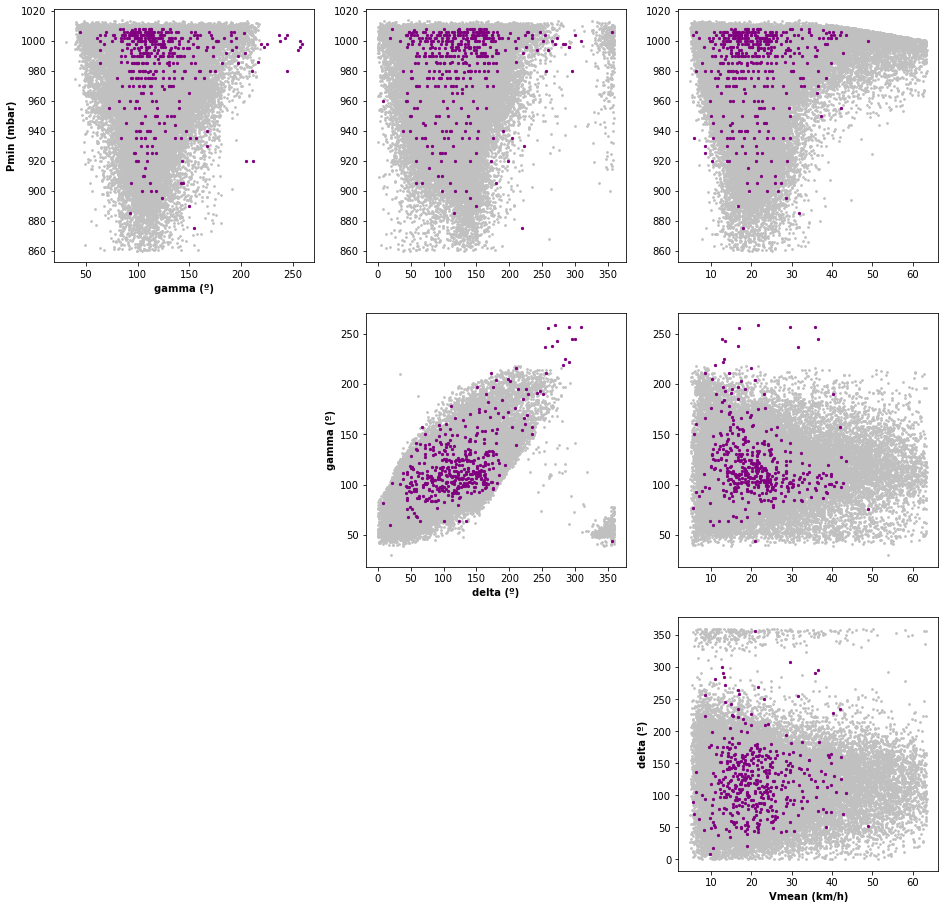

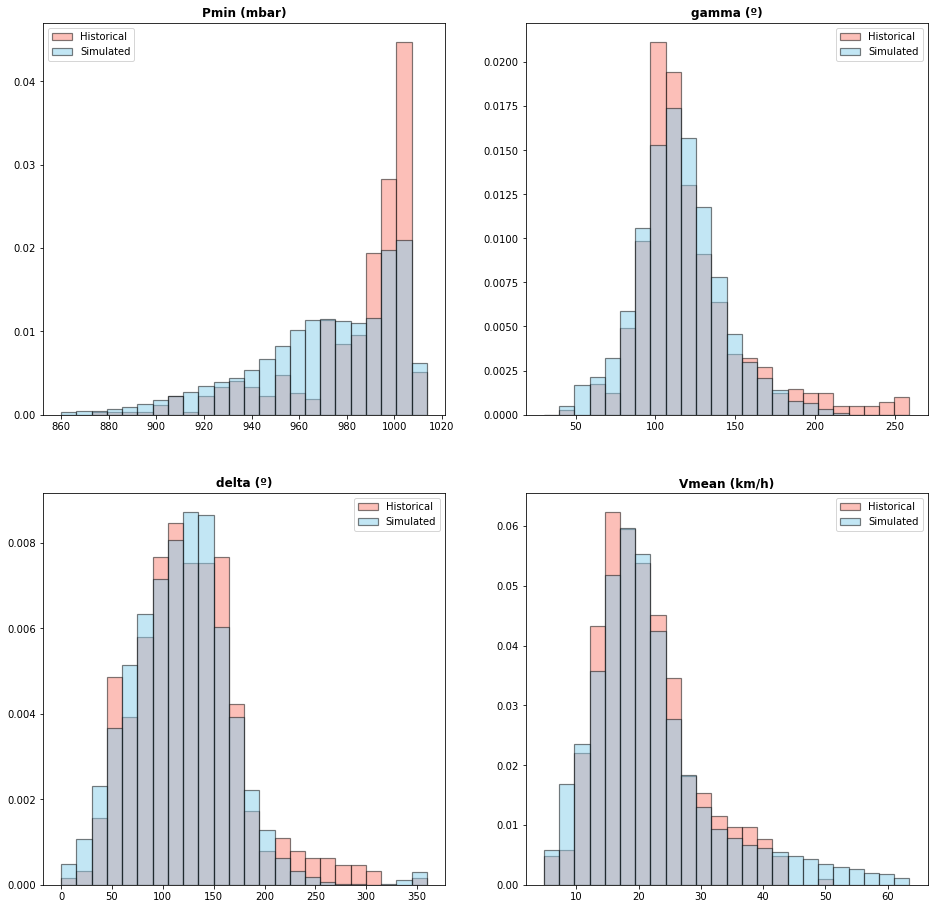

In [17]:
# scatter plot
Plot_TCs_Params_HISTvsSIM(TCs_r2_hist_params, TCs_r2_sim_params_filtered);

# histogram
Plot_TCs_Params_HISTvsSIM_histogram(TCs_r2_hist_params, TCs_r2_sim_params_filtered, 'Synthetic filtered');



## Simulated TCs - MaxDiss classification

In [18]:
categ_sim_cp = GetCategoryChangeProbs(TCs_r1_sim_params, TCs_r2_sim_params_filtered)
print(categ_sim_cp)
db.Save_TCs_probs_synth(categ_sim_cp)

<xarray.Dataset>
Dimensions:                  (category: 6)
Coordinates:
  * category                 (category) int64 0 1 2 3 4 5
Data variables:
    category_change_count    (category, category) int64 1952 5392 ... 0 3433
    category_change_probs    (category, category) float64 0.04485 ... 0.2278
    category_nochange_probs  (category) float64 0.9551 0.8402 ... 0.4415 0.4279
    category_change_cumsum   (category, category) float64 0.04485 ... 0.5721


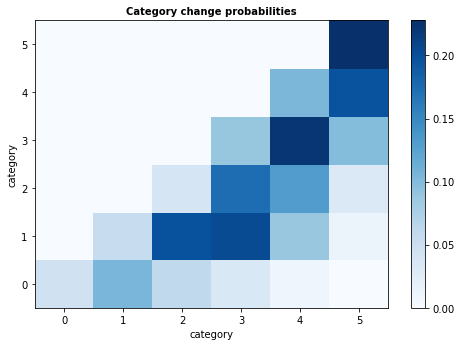

In [19]:
Plot_Category_Change(categ_sim_cp);

In [49]:
# --------------------------------------
# MaxDiss classification

#Set limits

# get simulated parameters  
pmean_s = TCs_r2_sim_params_filtered.pressure_mean.values
pmin_s  = TCs_r2_sim_params_filtered.pressure_min.values
gamma_s = TCs_r2_sim_params_filtered.gamma.values
delta_s = TCs_r2_sim_params_filtered.delta.values
vmean_s = TCs_r2_sim_params_filtered.velocity_mean.values

#Get historical parameters
pmean_hist = TCs_r2_hist_params.pressure_mean.values[:]
pmin_hist = TCs_r2_hist_params.pressure_min.values[:]
vmean_hist = TCs_r2_hist_params.velocity_mean.values[:]
delta_hist = TCs_r2_hist_params.delta.values[:]
gamma_hist = TCs_r2_hist_params.gamma.values[:]


# subset, scalar and directional indexes
data_mda = np.column_stack(( np.concatenate((pmin_s,pmin_hist)), np.concatenate((vmean_s,vmean_hist)),
                            np.concatenate((delta_s,delta_hist)), np.concatenate((gamma_s,gamma_hist))))
ix_scalar = [0,1]
ix_directional = [2,3]

# MDA
centroids = MaxDiss_Simplified_NoThreshold(
    data_mda, num_sel_mda, ix_scalar, ix_directional 
)


# store MDA storms - parameters 
TCs_r2_MDA_params = xr.Dataset(
    {
        'pressure_min':(('storm'), centroids[:,0]),
        'velocity_mean':(('storm'), centroids[:,1]),
        'delta':(('storm'), centroids[:,2]),
        'gamma':(('storm'), centroids[:,3]),
    },
    coords = {
        'storm':(('storm'), np.arange(num_sel_mda))    
    },
)
print(TCs_r2_MDA_params)

# db.Save_TCs_r2_mda_params(TCs_r2_MDA_params)


MaxDiss waves parameters: 50167 --> 500

   MDA centroids: 500/500

<xarray.Dataset>
Dimensions:        (storm: 500)
Coordinates:
  * storm          (storm) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    pressure_min   (storm) float64 1.014e+03 875.0 1e+03 ... 1.011e+03 906.4
    velocity_mean  (storm) float64 31.76 17.85 29.65 17.43 ... 46.52 8.329 15.76
    delta          (storm) float64 45.83 219.3 308.4 40.45 ... 252.7 216.7 184.3
    gamma          (storm) float64 84.36 154.5 256.6 119.5 ... 157.5 217.4 139.4


In [11]:
import pandas as pd

#Dataset

dataset = pd.read_pickle(r'/Users/laurac/Dropbox/Guam/teslakit/data/sites/GUAM/TCs/dataset_r2_Guam_Sara.pkl')
TCs_r2_sim_params_Sara = xr.Dataset(
    {
        'pressure_min':(('storm'), dataset.pmin),
        'gamma':(('storm'), dataset.gamma),
        'delta':(('storm'), dataset.delta),
        'velocity_mean':(('storm'), dataset.vmean),
    },
    coords = {
        'storm':(('storm'), np.arange(len(dataset.pmin)))    
    },
)

TCs_r2_sim_params_Sara
db.Save_TCs_r2_sim_params(TCs_r2_sim_params_Sara)

In [60]:
#MDA params from Sara --> Run HyTcWaves

#Subset
f='/Users/laurac/Dropbox/Guam/teslakit/data/sites/GUAM/TCs/subset_r2_Guam_mda500_Sara.pkl'
TCs_r2_MDA_params=pd.read_pickle(f)
TCs_r2_MDA_params=TCs_r2_MDA_params.to_xarray()

TCs_r2_MDA_params = xr.Dataset(
    {
        'pressure_min':(('storm'), TCs_r2_MDA_params.pmin),
        'velocity_mean':(('storm'), TCs_r2_MDA_params.vmean),
        'delta':(('storm'), TCs_r2_MDA_params.delta),
        'gamma':(('storm'), TCs_r2_MDA_params.gamma),
    },
    coords = {
        'storm':(('storm'), np.arange(num_sel_mda))    
    },
)
print(TCs_r2_MDA_params)
db.Save_TCs_r2_mda_params(TCs_r2_MDA_params)

<xarray.Dataset>
Dimensions:        (storm: 500)
Coordinates:
  * storm          (storm) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    pressure_min   (storm) float64 1.014e+03 875.0 998.9 ... 946.8 918.4
    velocity_mean  (storm) float64 31.76 17.85 62.3 12.66 ... 21.02 17.98 28.95
    delta          (storm) float64 45.83 219.3 199.9 300.0 ... 190.0 47.99 54.52
    gamma          (storm) float64 84.36 154.5 207.8 244.5 ... 106.6 82.49 74.52


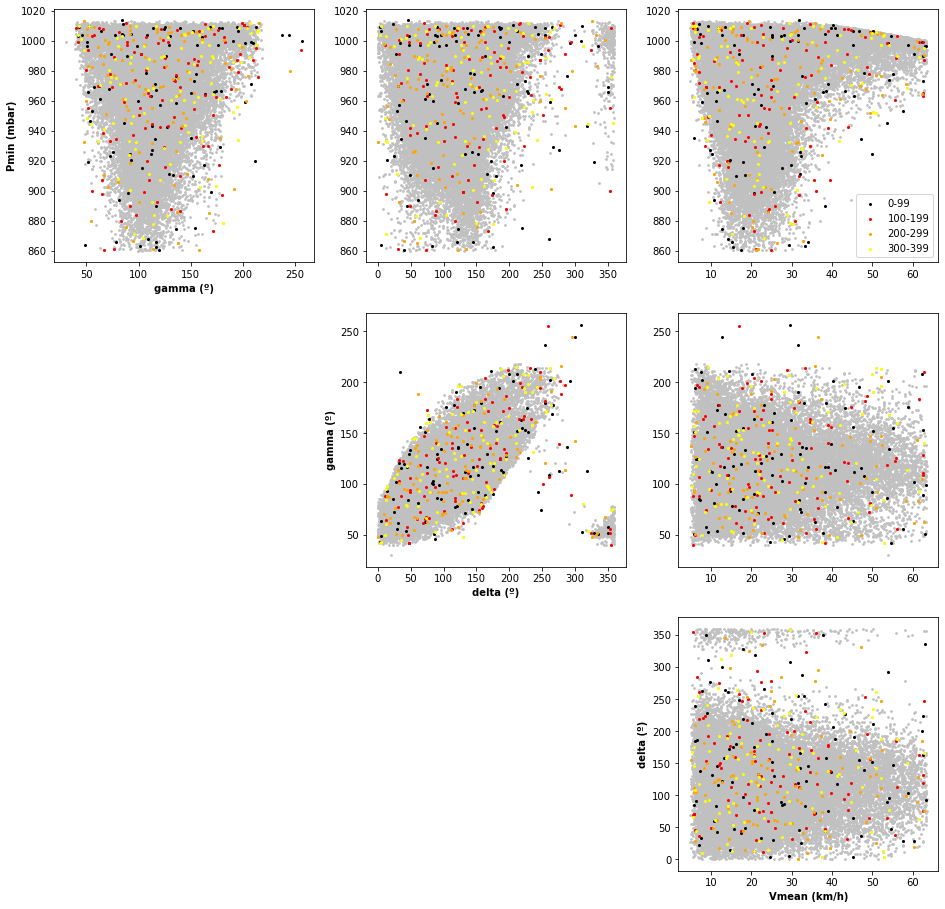

In [61]:
# Historical vs Simulated: scatter plot parameters
Plot_TCs_Params_MDAvsSIM(TCs_r2_MDA_params, TCs_r2_sim_params_filtered);


## Nakajo TCs (MDA centroids) Waves Simulation

Waves data is generated by numerically simulating selected storms. 

This methodology is not included inside teslakit python library.

This step needs to be done before continuing with notebook 07
